# Big Data Analytics - Project 03
# By Chaya Chandana Doddaiggaluru Appajigowda
# GWID: G35408608

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, expr, when
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder.appName("Read_File").getOrCreate()

file_path = '/content/drive/My Drive/BDA_Project 3/data'
df = spark.read.parquet(file_path)

In [ ]:
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

print(f"Shape: ({num_rows}, {num_columns})")

Shape: (77072751, 21)


This code identifies high-demand taxi regions in NYC by aggregating pickup data on a monthly basis and visualizing it through a heatmap. This allows for easy identification of demand hotspots in different parts of the city over time.

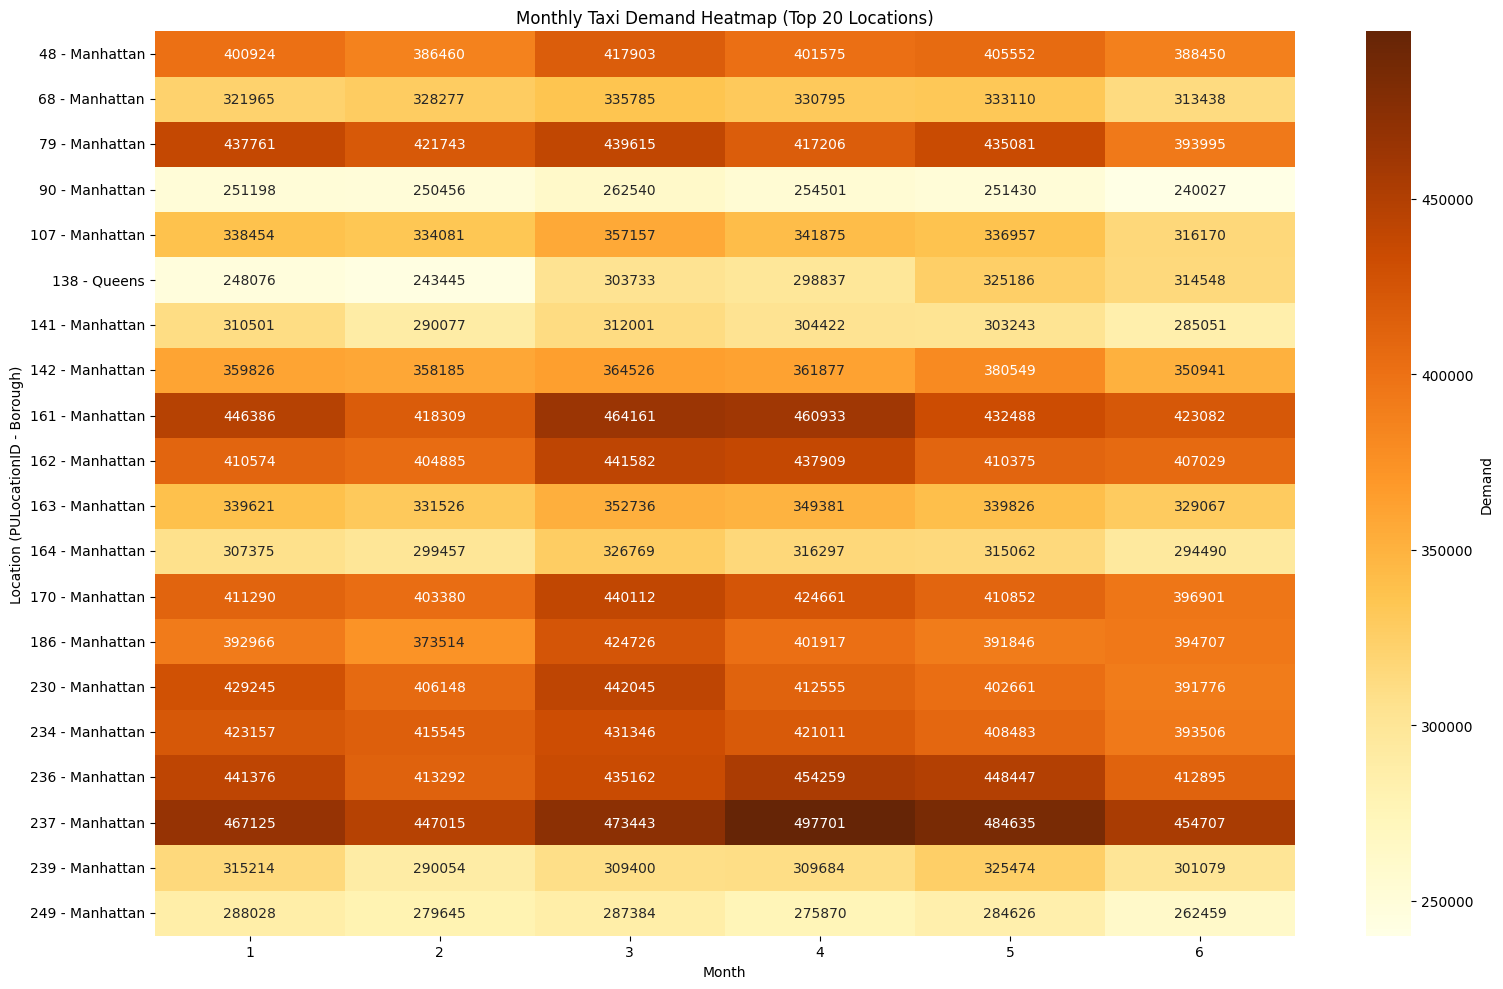

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Add a month column extracted from the pickup datetime
df = df.withColumn("month", F.month("tpep_pickup_datetime"))

# Aggregate to get monthly demand per PULocationID
monthly_demand = (
    df.groupBy("PULocationID", "month", "Pickup_Borough")
    .count()
    .withColumnRenamed("count", "monthly_demand")
)

# Get top 20 PULocationIDs by overall demand
top_20_locations = (
    monthly_demand.groupBy("PULocationID", "Pickup_Borough")
    .agg(F.sum("monthly_demand").alias("total_demand"))
    .orderBy(F.desc("total_demand"))
    .limit(20)
)

# Join to get the monthly demand data for these top 20 locations only
top_20_monthly_demand = (
    monthly_demand.join(top_20_locations, on=["PULocationID", "Pickup_Borough"], how="inner")
    .select("PULocationID", "Pickup_Borough", "month", "monthly_demand")
    .orderBy("month", "PULocationID")
)

# Convert Spark DataFrame to Pandas DataFrame, pivot, and fill missing values with 0
heatmap_data = (
    top_20_monthly_demand.toPandas()
    .pivot(index=["PULocationID", "Pickup_Borough"], columns="month", values="monthly_demand")
    .fillna(0)
)

# Reset index to make PULocationID and Pickup_Borough separate columns
heatmap_data = heatmap_data.reset_index()

# Create labels combining PULocationID and Borough
heatmap_data['label'] = heatmap_data['PULocationID'].astype(str) + ' - ' + heatmap_data['Pickup_Borough']

# Set the label as the index
heatmap_data = heatmap_data.set_index('label')

# Drop the original PULocationID and Pickup_Borough columns
heatmap_data = heatmap_data.drop(['PULocationID', 'Pickup_Borough'], axis=1)

# Set up the figure size
plt.figure(figsize=(16, 10))

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlOrBr",
    cbar_kws={'label': 'Demand'}
)

# Set the title and labels
plt.title("Monthly Taxi Demand Heatmap (Top 20 Locations)")
plt.xlabel("Month")
plt.ylabel("Location (PULocationID - Borough)")

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

## **Monthly Taxi Demand Heatmap for Top 20 Locations**
This heatmap visualizes the monthly taxi demand for the top 20 pickup locations in New York City over six months. The color intensity represents demand, with darker colors indicating higher demand.

Key observations:

- Location 237 (Manhattan) has consistently high demand across all months, especially in June, where it peaks at nearly 500,000 pickups.
-Other high-demand locations include Location 48, Location 161, and Location 162, all in Manhattan.
- The heatmap clearly shows that most high-demand locations are concentrated in Manhattan, with only a few exceptions like Location 138 (Queens).

In [ ]:
import plotly.express as px

# Reuse the top_20_monthly_demand DataFrame we created earlier
bar_data = top_20_monthly_demand.toPandas()

# Filter data to include only the first 6 months
bar_data = bar_data[bar_data["month"].isin(range(1, 7))]

# Create a combined label for PULocationID and Borough
bar_data["Location"] = bar_data["PULocationID"].astype(str) + " - " + bar_data["Pickup_Borough"]

# Sort by total demand and limit to top 5 locations
top_locations = (
    bar_data.groupby("Location")["monthly_demand"]
    .sum()
    .nlargest(10)
    .index
)
bar_data = bar_data[bar_data["Location"].isin(top_locations)]

# Create the stacked bar plot
fig = px.bar(
    bar_data,
    x="month",
    y="monthly_demand",
    color="Location",
    labels={"monthly_demand": "Monthly Demand", "month": "Month", "Location": "Location (ID - Borough)"},
    title="Monthly Taxi Demand for Top 10 Locations (First 6 Months)",
    barmode="stack",  # Use stacked bars instead of grouped bars
    color_discrete_sequence=px.colors.qualitative.Plotly
)

# Update layout for better appearance
fig.update_layout(
    height=800,
    width=1000,
    xaxis=dict(
        title="Month",
        tickmode="array",
        tickvals=list(range(1, 7)),
        ticktext=["Jan", "Feb", "Mar", "Apr", "May", "Jun"],
        tickangle=0
    ),
    yaxis=dict(title="Monthly Demand"),
    legend_title_text="Location (ID - Borough)",
    template="plotly_white",
    title=dict(x=0.5, xanchor="center")
)

# Add hover information
fig.update_traces(
    hovertemplate="<b>%{x}</b><br>Location: %{color}<br>Demand: %{y:,}<extra></extra>"
)

fig.show()

## **Monthly Taxi Demand for Top 10 Locations**
This stacked bar chart shows the monthly taxi demand for the top 10 pickup locations in Manhattan over the first six months of the year. Each color represents a different location, and the height of each bar corresponds to the total demand for that month.

Key observations:

- The overall monthly demand remains relatively consistent across months, fluctuating between approximately 4 million pickups.
- Location 237 (Manhattan) consistently has the highest demand every month, followed by Location 48 and Location 79.
- The demand distribution across locations is fairly even, with no single location dominating the demand entirely.

This plot helps visualize how taxi demand is distributed across different locations over time.

# Q3: Segment passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, expr, when
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder.appName("Read_File").getOrCreate()

file_path = '/content/drive/My Drive/BDA_Project 3/data/filtered_data.parquet'
df = spark.read.parquet(file_path)
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|          79|         231|       2| 2015-0

In [ ]:
from pyspark.sql.functions import avg

# Calculate the average trip distance
average_trip_distance = df.select(avg("trip_distance")).first()[0]

print(f"Average Trip Distance: {average_trip_distance:.2f} miles")

Average Trip Distance: 3.10 miles


In [ ]:
from pyspark.sql.functions import when

# Calculate percentiles for trip_distance
percentiles = df.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.01)
p25, p50, p75 = percentiles

# Create a new column 'distance_category' based on the calculated percentiles
df = df.withColumn(
    "distance_category",
    when(col("trip_distance") <= p25, "Very Short Distance")  # 0 to 25th percentile
    .when((col("trip_distance") > p25) & (col("trip_distance") <= p50), "Short Distance")  # 25th to 50th percentile
    .when((col("trip_distance") > p50) & (col("trip_distance") <= p75), "Medium Distance")  # 50th to 75th percentile
    .otherwise("Long Distance")  # 75th to 100th percentile
)

# Display the DataFrame with the new 'distance_category' column
df.select("trip_distance", "distance_category").show()

+-------------+-------------------+
|trip_distance|  distance_category|
+-------------+-------------------+
|          1.2|     Short Distance|
|          1.2|     Short Distance|
|          0.6|Very Short Distance|
|          0.8|Very Short Distance|
|          0.0|Very Short Distance|
|         0.03|Very Short Distance|
|          0.0|Very Short Distance|
|          0.0|Very Short Distance|
|          0.0|Very Short Distance|
|          0.7|Very Short Distance|
|          2.4|    Medium Distance|
|          0.8|Very Short Distance|
|          3.3|      Long Distance|
|         1.07|     Short Distance|
|         7.76|      Long Distance|
|          1.6|     Short Distance|
|          0.5|Very Short Distance|
|          1.7|    Medium Distance|
|         8.45|      Long Distance|
|          0.0|Very Short Distance|
+-------------+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, when

# Step 1: Calculate quantiles for total_fare
quantiles = df.approxQuantile("total_fare", [0.33, 0.66], 0.01)  # 33rd and 66th percentiles
q1, q2 = quantiles[0], quantiles[1]  # Unpack quantile values

# Print quantiles for verification
print(f"Q1 (33rd Percentile): {q1}")
print(f"Q2 (66th Percentile): {q2}")

# Step 2: Create fare segments based on quantiles
df = df.withColumn(
    "fare_segment",
    when(col("total_fare") < q1, "Low Fare")  # Below Q1
    .when((col("total_fare") >= q1) & (col("total_fare") < q2), "Medium Fare")  # Between Q1 and Q2
    .otherwise("High Fare")  # Above Q2
)

# Step 3: Verify segmentation by counting rows in each segment
segmentation_counts = df.groupBy("fare_segment").count()

# Show the segmentation counts
segmentation_counts.show()


Q1 (33rd Percentile): 9.3
Q2 (66th Percentile): 13.8
+------------+-------+
|fare_segment|  count|
+------------+-------+
|    Low Fare|5492415|
| Medium Fare|5503132|
|   High Fare|5852800|
+------------+-------+



In [ ]:
# Drop the time_of_day column
df = df.drop("time_of_day")

# Verify the column has been removed
#df.printSchema()


root
 |-- DOLocationID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- Pickup_Borough: string (nullable = true)
 |-- Dropoff_Borough: string (nullable = true)
 |-- payment_type_0: integer (nullable = true)
 |-- payment_type_5: integer (nullable = true)
 |-- payment_type_1: integer (nullable = true)
 |-- payment_type_3: integer (nullable = true)
 |-- payment_type_2: integer (nullable = true)
 |-- payment_type_4: integer 

In [ ]:
df = df.drop('time interval')

In [ ]:
from pyspark.sql.functions import col, concat_ws, lit, floor

# Create a new column for 3-hour time intervals
df = df.withColumn(
    "time_interval",
    concat_ws(
        "-",
        (floor(col("pickup_hour") / 3) * 3).cast("string"),  # Start of the interval
        ((floor(col("pickup_hour") / 3) * 3) + 3).cast("string")  # End of the interval
    )
)

# Verify the new column
df.select("trip_distance","distance_category","fare_segment", "time_interval").show(10)


+-------------+-------------------+------------+-------------+
|trip_distance|  distance_category|fare_segment|time_interval|
+-------------+-------------------+------------+-------------+
|          1.2|     Short Distance| Medium Fare|          0-3|
|          1.2|     Short Distance| Medium Fare|          0-3|
|          0.6|Very Short Distance| Medium Fare|          0-3|
|          0.8|Very Short Distance|    Low Fare|          0-3|
|          0.0|Very Short Distance|    Low Fare|          0-3|
|         0.03|Very Short Distance|    Low Fare|          0-3|
|          0.0|Very Short Distance|    Low Fare|          0-3|
|          0.0|Very Short Distance|    Low Fare|        15-18|
|          0.0|Very Short Distance|    Low Fare|        15-18|
|          0.7|Very Short Distance| Medium Fare|          0-3|
+-------------+-------------------+------------+-------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import count

# Aggregate the data in PySpark
aggregated_df = df.groupBy("time_interval", "distance_category", "fare_segment").agg(
    count("*").alias("count")
)

# Convert to Pandas
aggregated_pd = aggregated_df.toPandas()

# Ensure `time_interval` is in categorical order
aggregated_pd["time_interval"] = pd.Categorical(
    aggregated_pd["time_interval"],
    categories=[
        "0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"
    ],
    ordered=True
)

In [ ]:
import plotly.express as px
import pandas as pd

# Convert `time_interval` to a categorical type with a specific order
aggregated_pd["time_interval"] = pd.Categorical(
    aggregated_pd["time_interval"],
    categories=[
        "0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"
    ],
    ordered=True
)

# Create the Plotly bar chart
fig = px.bar(
    aggregated_pd,
    x="time_interval",
    y="count",
    color="distance_category",
    facet_col="fare_segment",
    barmode="stack",
    title="Distance Category and Fare Segment Distribution Across Time Intervals",
    labels={
        "time_interval": "Time Interval (3-Hour Bins)",
        "count": "Trip Count",
        "distance_category": "Distance Category"
    },
    height=700,  # Adjust height for better spacing
    width=1200   # Adjust width for better spacing
)

# Adjust legend layout to avoid overlap
fig.update_layout(
    legend=dict(
        title="Distance Category",
        orientation="h",  # Horizontal legend
        y=-0.2,           # Position the legend below the chart
        x=0.5,            # Center the legend horizontally
        xanchor="center"
    ),
    xaxis=dict(categoryorder="array", categoryarray=[
        "0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"
    ])  # Explicitly set order for X-axis
)

# Customize chart layout
fig.update_layout(
    margin=dict(l=50, r=50, t=100, b=150),  # Adjust margins for better spacing
    title=dict(x=0.5, font=dict(size=20))   # Center the title
)

# Show the chart
fig.show()


## Interpretation

### High Fare Segment
Trips classified as Long Distance make up the majority of the high-fare segment, especially during the hours of 9 AM - 12 PM, 6 PM - 9 PM, and 9 PM - 12 AM.

Medium and short-distance trips contribute less to the high-fare category and are most active between 12 PM - 9 PM.

### Low Fare Segment
This segment mainly consists of Very Short Distance or Short Distance trips. Demand rises during the daytime, with peak activity between 9 AM - 9 PM. There is less demand after 9 PM, indicating fewer short trips during nighttime hours.

### Medium Fare Segment
The medium-fare category is largely made up of a combination of Medium and Short Distance trips, especially during 12 PM - 9 PM. Long Distance trips show notable growth in this segment during the evening hours of 6 PM - 12 AM.

### Time-of-Day Trends
The morning peak (6 AM - 9 AM) has lower activity across all fare levels. The daytime (9 AM - 6 PM) and evening (6 PM - 12 AM) periods see the highest trip volumes across fare levels and trip distances.

### Distance-Based Segmentation
Very Short Distance and Short Distance trips are prevalent in the low-fare segment, while Long Distance trips dominate high fares, particularly during evening hours.


In [ ]:
import plotly.express as px
import pandas as pd

# Step 1: Filter the data for "Credit Card" and "Cash"
filtered_pd = aggregated_pd[aggregated_pd["payment_type"].isin(["Credit Card", "Cash"])]

# Step 2: Ensure `time_interval` is categorized for proper ordering
filtered_pd["time_interval"] = pd.Categorical(
    filtered_pd["time_interval"],
    categories=["0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"],
    ordered=True
)

# Step 3: Create the Plotly bar chart with patterns and colors
fig = px.bar(
    filtered_pd,
    x="time_interval",
    y="count",
    color="fare_segment",  # Use colors for fare segments
    pattern_shape="payment_type",  # Use patterns for payment types (Credit Card, Cash)
    barmode="group",               # Side-by-side bars for payment types
    title="Cash and Credit Card Trip Count by Time Interval (With Patterns and Colors)",
    labels={
        "time_interval": "Time Interval (3-Hour Bins)",
        "count": "Trip Count",
        "payment_type": "Payment Type",
        "fare_segment": "Fare Segment"
    },
    height=700,
    width=1200
)

# Step 4: Customize the legend to show patterns and colors
fig.update_traces(marker=dict(line=dict(width=0.5)),  # Optional: Add thin borders around bars
                  selector=dict(type='bar'))

fig.update_layout(
    legend=dict(
        title="Payment Type & Fare Segment",
        orientation="h",
        y=-0.2,
        x=0.5,
        xanchor="center"
    ),
    xaxis=dict(categoryorder="array", categoryarray=[
        "0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"
    ])
)

# Step 5: Customize legend to show both patterns and colors
fig.for_each_trace(lambda t: t.update(name=f"{t.name}, {t.legendgroup}", legendgroup=t.legendgroup, showlegend=True))

# Step 6: Display the chart
fig.show()


<ipython-input-60-c12fd9f1314a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Analysis of Payment Type & Fare Segment Distribution Across Time Intervals

The bar chart illustrates the distribution of taxi trips segmented by *fare category* (Low, Medium, High Fare) and *payment method* (Credit Card, Cash) across various *3-hour time intervals*.

#### Key Insights:
1. *Payment Preferences*:
   - *Credit Card* payments are the predominant method across all fare categories, especially during peak hours between 12 PM and 9 PM.
   - *Cash* payments are less common overall but show greater frequency for high-fare trips, particularly in the early morning hours (0-6 AM).

2. *Fare Categories*:
   - *Low Fare* trips are the most frequent across all time intervals, with credit cards being the preferred payment method.
   - *Medium Fare* and *High Fare* trips maintain consistent demand, with a significant increase observed in the evening (6 PM - 12 AM).

3. *Time-of-Day Patterns*:
   - *0-3 AM*: High-fare trips paid in cash are more frequent, potentially indicating longer or late-night travel.
   - *12 PM - 9 PM*: This period shows peak activity across all fare categories, with credit card payments leading in all segments.
   - *9 PM - 12 AM*: Demand remains strong, particularly for Medium Fare trips.

4. *Cash vs. Credit Card Usage*:
   - *Cash payments* are notably higher for high fares during late-night and early morning hours (0-6 AM), possibly reflecting passenger payment preferences or limited availability of card options at these times.


In [ ]:
# Count values where trip_duration is less than 3
count_less_than_0 = df.filter(col("trip_duration") < 3).count()

# Count values where trip_duration is greater than 60
count_greater_than_60 = df.filter(col("trip_duration") > 60).count()

# Display the results
print(f"Count of trip_duration less than 0: {count_less_than_0}")
print(f"Count of trip_duration greater than 60: {count_greater_than_60}")


Count of trip_duration less than 0: 3913456
Count of trip_duration greater than 60: 556587


In [ ]:
# Filter out rows where trip_duration is less than 3 or greater than 60
df = df.filter((col("trip_duration") >= 3) & (col("trip_duration") <= 60))

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
from pyspark.sql.functions import when

# Define distance bins from 0-1, 1-2, ..., 9-10
df = df.withColumn(
    "distance_bin",
    when((col("trip_distance") >= 0) & (col("trip_distance") < 1), "0-1")
    .when((col("trip_distance") >= 1) & (col("trip_distance") < 2), "1-2")
    .when((col("trip_distance") >= 2) & (col("trip_distance") < 3), "2-3")
    .when((col("trip_distance") >= 3) & (col("trip_distance") < 4), "3-4")
    .when((col("trip_distance") >= 4) & (col("trip_distance") < 5), "4-5")
    .when((col("trip_distance") >= 5) & (col("trip_distance") < 6), "5-6")
    .when((col("trip_distance") >= 6) & (col("trip_distance") < 7), "6-7")
    .when((col("trip_distance") >= 7) & (col("trip_distance") < 8), "7-8")
    .when((col("trip_distance") >= 8) & (col("trip_distance") < 9), "8-9")
    .when((col("trip_distance") >= 9) & (col("trip_distance") <= 10), "9-10")
    .otherwise("10+")
)

# Group by distance_bin and count the number of rows in each bin
distance_bin_counts = df.groupBy("distance_bin").count()

# Show the counts for each distance bin
distance_bin_counts.show()

+------------+--------+
|distance_bin|   count|
+------------+--------+
|         3-4| 6369687|
|         2-3|12632640|
|         7-8| 1037233|
|         1-2|25554030|
|         10+| 3583012|
|         4-5| 3602105|
|         5-6| 2290781|
|         6-7| 1496947|
|         0-1|14106498|
|         8-9|  946553|
|        9-10|  983222|
+------------+--------+



In [ ]:
# Filter out rows where trip_distance is between 0 and 1
df = df.filter(~((col("trip_distance") >= 0) & (col("trip_distance") < 1)))

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
# Count values where trip_distance is greater than 60
count_greater_than_60 = df.filter(col("trip_distance") > 60).count()

# Display the result
count_greater_than_60

0

In [ ]:
# Filter out rows where trip_distance is greater than 60
df = df.filter(col("trip_distance") <= 60)

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
# Display the count of rows in the DataFrame `df`
row_count = df.count()

# Show the result
row_count

58495256

In [ ]:
# Get the count of each unique value in the `passenger_count` column
passenger_count_counts = df.groupBy("passenger_count").count().orderBy("passenger_count")
passenger_count_counts.show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|              0|   24658|
|              1|41134547|
|              2| 8423150|
|              3| 2464061|
|              4| 1177595|
|              5| 3203338|
|              6| 2067818|
|              7|      44|
|              8|      21|
|              9|      24|
+---------------+--------+



In [ ]:
# Filter out rows where passenger_count is null, 0.0, or greater than 5
df = df.filter((col("passenger_count").isNotNull()) & (col("passenger_count") > 0) & (col("passenger_count") <= 5))

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
row_count = df.count()

# Show the result
row_count

56351000

In [ ]:
# Count values where total_fare is greater than 300
count_above_300 = df.filter(col("total_fare") <0).count()

# Display the result
count_above_300

0

In [ ]:
# Filter out rows where total_fare is greater than 300
df = df.filter(col("total_fare") <= 100)

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
# Count values where tip_amount is greater than 100
count_tip_above_100 = df.filter(col("tip_amount") < 0).count()

# Display the result
count_tip_above_100

0

In [ ]:
# Filter out rows where tip_amount is greater than 100
df = df.filter(col("tip_amount") <= 100)

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:
# Count values where tolls_amount is greater than 16
count_tolls_above_16 = df.filter(col("tolls_amount") >16).count()

# Display the result
count_tolls_above_16

26452

In [ ]:
# Filter out rows where tolls_amount is greater than 16
df = df.filter(col("tolls_amount") <=16)

# Display the resulting DataFrame to confirm the filtering
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|        total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_4|payment_type_3|payment_type_2|payment_type_5|payment_type_1|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+------------------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+
|         145|         138|       1| 2015-0

In [ ]:

# Specify the path to save the new Parquet file
output_path = '/content/drive/My Drive/Colab Notebooks/BDA_Proj03/data/filtered_data.parquet'

# Write the filtered DataFrame to a new Parquet file
df.write.mode("overwrite").parquet(output_path)

print("Filtered dataset has been saved to:", output_path)

Filtered dataset has been saved to: /content/drive/My Drive/Colab Notebooks/BDA_Proj03/data/filtered_data.parquet


# Q2: Predict the duration of a taxi trip based on trip start time and location (pick up and dropoff)


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("TaxiTripDurationPrediction").getOrCreate()
# Select necessary columns and drop rows with null values
df = df.select("PULocationID", "DOLocationID", "trip_distance", "total_fare", "trip_duration").dropna()

# Index the PULocationID and DOLocationID columns
pulocation_indexer = StringIndexer(inputCol="PULocationID", outputCol="PULocationID_index")
dolocation_indexer = StringIndexer(inputCol="DOLocationID", outputCol="DOLocationID_index")

df = pulocation_indexer.fit(df).transform(df)
df = dolocation_indexer.fit(df).transform(df)

# Assemble the indexed and numerical features into a single feature vector
feature_columns = ["PULocationID_index", "DOLocationID_index", "trip_distance", "total_fare"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the model
lr = LinearRegression(featuresCol="features", labelCol="trip_duration")
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)
predictions.select("trip_duration", "prediction").show()

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

+-------------+------------------+
|trip_duration|        prediction|
+-------------+------------------+
|        30.72|23.495226375079238|
|        26.55| 71.32382237518468|
|         50.4| 33.25755374691845|
|        19.97|16.556531473283624|
|        12.57|  11.7980116718796|
|         36.9| 34.73949948125577|
|        14.25| 17.58218910159098|
|        45.37| 71.32765543172745|
|         6.38|  9.46978672201308|
|         6.02| 8.036440507806955|
|         5.52|  8.72333581061162|
|        13.72| 13.53160293024428|
|          7.4| 9.918459590430565|
|         7.28| 9.799348373236976|
|        10.17| 12.93604684427633|
|        16.65|14.480584144851436|
|        15.42| 14.41310840543003|
|        28.55|22.441699251997104|
|        20.48| 20.00464789081457|
|        28.17|20.981401105778605|
+-------------+------------------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on test data: 4.7519428526282805


### Explanation of the Output

The output provides two key results:

1. **Predicted vs. Actual Trip Durations:**  
   The table displays the actual and predicted values of `trip_duration` for the first 20 rows in the test data. Each row represents a trip where:
   - `trip_duration` is the actual duration of the trip.
   - `prediction` is the model’s predicted duration based on the input features.

2. **Root Mean Squared Error (RMSE):**  
   RMSE is a commonly used metric to evaluate the performance of regression models. It calculates the average magnitude of errors between the predicted and actual values. In this output, the RMSE is approximately `4.75`, which indicates that, on average, the model’s predictions are off by 4.75 minutes when predicting `trip_duration`.

### Analysis

#### 1. Prediction Accuracy:
   - The model has done reasonably well on certain predictions, especially for shorter trip durations. For example, the prediction for a trip with an actual duration of 19.97 minutes was 16.56 minutes—quite close.
   - However, for some longer trips, the predictions are less accurate. For instance, the model predicted 71.32 minutes for a trip with an actual duration of 26.55 minutes, indicating a larger error.

#### 2. Root Mean Squared Error (RMSE):
   - The RMSE of 4.75 suggests that there is moderate error in the model’s predictions. In taxi trip duration prediction, an RMSE around this value might be acceptable depending on the context, but there could likely be room for improvement.
   - A lower RMSE would mean that the predictions are closer to the actual values on average. For instance, an RMSE closer to 1-2 minutes would indicate a high-performing model, while a higher RMSE would indicate more room for improvement.


In [ ]:
df_new_trip =df[df['trip_duration'] ==26.55]
df_new_trip.show()

+------------+------------+-------------+------------------+-------------+------------------+------------------+
|PULocationID|DOLocationID|trip_distance|        total_fare|trip_duration|PULocationID_index|DOLocationID_index|
+------------+------------+-------------+------------------+-------------+------------------+------------------+
|         132|         186|        16.73|58.129999999999995|        26.55|              19.0|               7.0|
|         161|         138|        10.24|38.129999999999995|        26.55|               1.0|              24.0|
|          87|         107|          4.1|              21.8|        26.55|              42.0|              15.0|
|         236|         234|          3.6|              19.8|        26.55|               6.0|               6.0|
|          48|          14|        11.77|41.129999999999995|        26.55|               9.0|              93.0|
|         132|         234|        17.93|58.129999999999995|        26.55|              19.0|   

# Q4: Predict whether a passenger will pay by card or cash

## Payment Type Data Preparation and Analysis


In [ ]:
from pyspark.sql.functions import when, col

# Create target variable
df = df.withColumn("payment_type",
                   when(col("payment_type_1") == 1, 1)
                   .when(col("payment_type_2") == 1, 0)
                   .otherwise(None))

# Drop rows with other payment types
df = df.filter(col("payment_type").isNotNull())

# Drop original payment type columns
columns_to_drop = ["payment_type_1", "payment_type_2", "payment_type_3", "payment_type_4", "payment_type_5"]
df = df.drop(*columns_to_drop)

# Show the updated schema and sample data
print("Updated Schema:")
df.printSchema()

print("\nUpdated Sample Data:")
df.show(5)

# Check the distribution of the target variable
print("\nPayment Type Distribution:")
df.groupBy("payment_type").count().show()

Updated Schema:
root
 |-- DOLocationID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- Pickup_Borough: string (nullable = true)
 |-- Dropoff_Borough: string (nullable = true)
 |-- payment_type_0: integer (nullable = true)
 |-- payment_type: integer (nullable = true)


Updated Sample Data:
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+

Data Transformation:
- 1 represents card payments
- 0 represents cash payments

Data Cleaning:

Removes rows with other payment types
Drops the original payment type columns to simplify the dataset
Distribution Analysis:

The payment type distribution shows:
- Card payments (1): 8,788,837 rides (76.1%)
- Cash payments (0): 2,759,148 rides (23.9%)

This indicates a significant imbalance in the dataset, with card payments being more than three times more common than cash payments. This imbalance should be considered when building the prediction model to ensure fair treatment of both payment types.

The schema shows all relevant features that could influence payment type prediction, including:
Location IDs
- Trip details (distance, duration, passenger count)
- Temporal information (pickup datetime)
- Fare information (total amount, tip amount)
- Geographic information (pickup and dropoff boroughs)



## Correlation Analysis of Numerical Features
This code creates a correlation heatmap to analyze relationships between numerical features in the taxi dataset. Key observations from the heatmap:

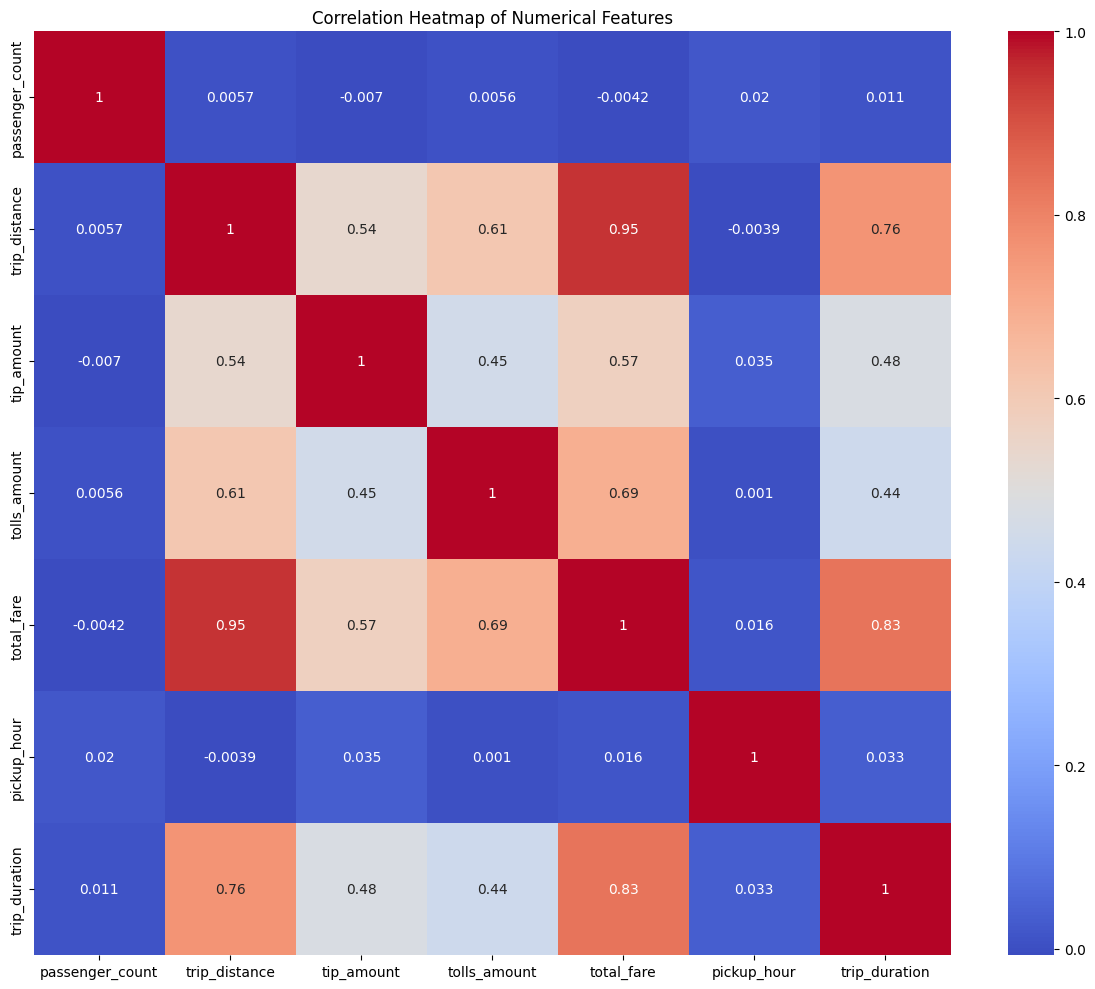

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("TaxiDataAnalysis").getOrCreate()

numerical_features = ['passenger_count', 'trip_distance', 'tip_amount', 'tolls_amount', 'total_fare', 'pickup_hour', 'trip_duration']

# Create a vector of features
vector_col = "features"
assembler = VectorAssembler(inputCols=numerical_features, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col, "payment_type")

# Compute correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()

# Convert to Pandas for visualization (only the correlation matrix, not the entire dataset)
corr_df = spark.createDataFrame(corr_matrix, numerical_features).toPandas()

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", xticklabels=numerical_features, yticklabels=numerical_features)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


**Strong Positive Correlations**:

Total fare and trip distance (0.95): Indicates fare is heavily dependent on distance traveled

Trip duration and total fare (0.83): Longer trips generally cost more

Trip duration and trip distance (0.76): Longer distances naturally take more time

Tolls amount and trip distance (0.61): Longer trips are more likely to incur toll charges

**Moderate Correlations:**

Tip amount and trip distance (0.54): Passengers tend to give higher tips for longer trips

Tip amount and total fare (0.57): Higher fares generally result in higher tips

Tolls amount and total fare (0.69): Toll charges contribute to the total fare

**Weak or No Correlations**

Passenger count shows minimal correlation with other features (all correlations < 0.02)

Pickup hour has very weak correlations with all other features (all correlations < 0.04)

Tolls amount and tip amount show moderate correlation (0.45)
This correlation analysis helps identify which features might be most important for predicting payment type and understanding the relationships between different aspects of taxi trips.

In [ ]:
from pyspark.sql import functions as F
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# 1. Payment Type Distribution
payment_dist = df.groupBy("payment_type").count().toPandas()
fig1 = px.pie(payment_dist, values='count', names='payment_type',
              title='Payment Type Distribution',
              labels={0: 'Non-Cash', 1: 'Cash'})
fig1.show()

### Analysis of Payment Type Distribution

The pie chart illustrates the distribution of payment types for taxi trips, categorized into two groups: Cash (1) and Non-Cash (0).

#### Key Observations:
1. **Non-Cash Payments** dominate the transactions, representing **76.1%** of all trips. This suggests that the majority of passengers prefer using digital or card-based payment methods, potentially for convenience or availability.

2. **Cash Payments** make up **23.9%** of transactions, indicating a smaller, but still significant, portion of passengers who prefer cash. This might reflect a subset of customers who either don’t have access to non-cash options or prefer cash for various reasons.

This distribution indicates a strong preference for non-cash payments, which aligns with broader trends toward digital transactions in many sectors.

In [ ]:
# 2. Average Trip Distance by Payment Type
avg_distance = df.groupBy("payment_type").agg(
    F.avg("trip_distance").alias("avg_distance")
).toPandas()
fig2 = px.bar(avg_distance, x='payment_type', y='avg_distance',
              title='Average Trip Distance by Payment Type')
fig2.show()


### Analysis of Average Trip Distance by Payment Type

The bar chart shows the average trip distance for taxi rides based on the *payment type*, categorized as Non-Cash (0) and Cash (1).

#### Key Observations:
1. **Similar Average Distance:** The average trip distance for both payment types is very close, with only a slight difference between Non-Cash and Cash payments. This indicates that trip distance does not vary significantly based on whether the payment was made in cash or by a non-cash method.

2. **Implications:** The near-equal average distances for both payment types suggest that passengers’ choice of payment method is likely independent of trip length. Therefore, payment type does not seem to be a strong indicator of trip distance in this dataset.

This analysis shows that, regardless of payment preference, passengers tend to travel similar distances on average.


In [ ]:
# 3. Average Tip Amount by Payment Type
avg_tip = df.groupBy("payment_type").agg(
    F.avg("tip_amount").alias("avg_tip")
).toPandas()
fig3 = px.bar(avg_tip, x='payment_type', y='avg_tip',
              title='Average Tip Amount by Payment Type')
fig3.show()


### Analysis of Average Tip Amount by Payment Type

The bar chart displays the average tip amount for taxi rides based on the *payment type*, distinguishing between Non-Cash (0) and Cash (1) transactions.

#### Key Observations:
1. **Tips for Non-Cash Payments:** The chart shows that tips are recorded only for Cash payments (payment type 1). There is no bar representing Non-Cash payments, which suggests that tips might either be less frequently recorded or not provided at all in Non-Cash transactions within this dataset.

2. **Implications:** The presence of tips exclusively for Cash payments could indicate a limitation in how tipping data is captured for Non-Cash transactions. Alternatively, it may suggest that passengers paying with cash tend to tip more frequently or that digital payment systems do not encourage tipping in this dataset.

This analysis highlights a potential gap in tipping behavior and data recording between Cash and Non-Cash payments, with tips being primarily associated with Cash transactions.


In [ ]:
# 4. Payment Type Distribution by Hour
hourly_dist = df.groupBy("pickup_hour", "payment_type").count().toPandas()
fig4 = px.line(hourly_dist, x='pickup_hour', y='count', color='payment_type',
               title='Payment Type Distribution by Hour')
fig4.show()

### Analysis of Payment Type Distribution by Hour

The line chart shows the distribution of payment types (Cash = 1, Non-Cash = 0) for taxi trips across different hours of the day, with the count of trips on the y-axis and the pickup hour on the x-axis.

#### Key Observations:
1. **Dominance of Non-Cash Payments (Blue Lines):**
   - Non-Cash payments are consistently higher than Cash payments across all hours, suggesting a general preference for digital or card-based transactions.
   - There is a clear upward trend in Non-Cash payments as the day progresses, reaching peak counts in the late afternoon and evening hours, before decreasing slightly towards midnight.

2. **Cash Payments (Red Lines):**
   - Cash payments remain significantly lower than Non-Cash transactions throughout the day.
   - The volume of Cash payments shows less fluctuation across different hours, with a slight increase during the morning hours (5-9 AM) and then stabilizing.

3. **Time-of-Day Trends:**
   - Non-Cash payments peak in the late afternoon and evening hours, indicating high demand during these periods.
   - The lower activity for both payment types during early morning hours (0-5 AM) suggests less demand for taxi services during these hours.

4. **Implications:**
   - The preference for Non-Cash payments aligns with typical urban travel patterns where digital payment options are commonly preferred.
   - Cash payments, though less common, remain stable, possibly reflecting a specific user base or circumstances where Non-Cash options are unavailable or inconvenient.

This analysis highlights a strong preference for Non-Cash payments, especially during peak travel hours in the late afternoon and evening.

In [ ]:
# Step 2: Implement oversampling
def oversample_minority_class(df, minority_label=0, majority_label=1):
    # Get initial counts
    majority_count = df.filter(col("payment_type") == majority_label).count()
    minority_count = df.filter(col("payment_type") == minority_label).count()

    print(f"Before oversampling:")
    print(f"Majority class (1) count: {majority_count}")
    print(f"Minority class (0) count: {minority_count}")

    # Calculate scaling factor
    scaling_factor = float(majority_count) / minority_count
    print(f"Scaling factor for oversampling: {scaling_factor:.2f}")

    # Split into majority and minority datasets
    minority_df = df.filter(col("payment_type") == minority_label)
    majority_df = df.filter(col("payment_type") == majority_label)

    # Oversample minority class
    oversampled_minority = minority_df.sample(
        withReplacement=True,
        fraction=scaling_factor,
        seed=42
    )

    # Combine datasets
    balanced_df = majority_df.unionAll(oversampled_minority)

    # Print final distribution
    print("\nAfter oversampling:")
    balanced_df.groupBy("payment_type").count().orderBy("payment_type").show()

    return balanced_df

# Execute oversampling
balanced_df = oversample_minority_class(df)


Before oversampling:
Majority class (1) count: 8788837
Minority class (0) count: 2759148
Scaling factor for oversampling: 3.19

After oversampling:
+------------+-------+
|payment_type|  count|
+------------+-------+
|           0|8786126|
|           1|8788837|
+------------+-------+



### Analysis of Oversampling for Payment Type Imbalance

#### Before Oversampling:
- **Majority Class (1 - Cash payments)**: 8,788,837 instances
- **Minority Class (0 - Non-Cash payments)**: 2,759,148 instances
- **Scaling Factor**: 3.19, calculated to increase the count of the minority class to balance with the majority class.

#### After Oversampling:
The oversampling process has increased the minority class count to closely match the majority class, resulting in the following distribution:
- **Non-Cash Payments (0)**: 8,786,126 instances
- **Cash Payments (1)**: 8,788,837 instances

#### Key Observations:
1. **Balanced Distribution**: Both classes are now nearly equal in count, reducing the imbalance that could have biased the model towards the majority class.
2. **Impact on Model Performance**: With a balanced dataset, the model should now be better equipped to learn patterns for both classes, improving prediction accuracy, especially for the previously underrepresented Non-Cash payments.
3. **Potential Risks**: While oversampling addresses class imbalance, it increases the dataset size, potentially leading to longer training times and a risk of overfitting on the oversampled class. Additional regularization techniques or cross-validation can help mitigate these risks.

This balanced dataset will likely result in a more reliable model that performs well across both payment types.


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

def prepare_data(balanced_df):
    # First, let's create indexers for categorical features
    location_indexers = [
        StringIndexer(inputCol="DOLocationID", outputCol="DOLocationID_indexed"),
        StringIndexer(inputCol="PULocationID", outputCol="PULocationID_indexed"),
        StringIndexer(inputCol="pickup_hour", outputCol="pickup_hour_indexed")
    ]

    # Define all features including newly indexed ones
    feature_columns = [
        "trip_distance",
        "tip_amount",
        "total_fare",
        "trip_duration",
        "passenger_count",
        "DOLocationID_indexed",
        "PULocationID_indexed",
        "pickup_hour_indexed"
    ]

    # Print sample before transformation
    print("Sample of original data:")
    balanced_df.select("DOLocationID", "PULocationID", "pickup_hour", "trip_distance", "tip_amount").show(5)

    # Create vector assembler
    assembler = VectorAssembler(
        inputCols=feature_columns,
        outputCol="features"
    )

    # Create pipeline
    pipeline = Pipeline(stages=location_indexers + [assembler])

    # Fit and transform the data
    pipeline_model = pipeline.fit(balanced_df)
    vector_df = pipeline_model.transform(balanced_df)

    # Print sample after transformation
    print("\nSample after feature engineering:")
    vector_df.select("features", "payment_type",
                    "DOLocationID_indexed", "PULocationID_indexed",
                    "pickup_hour_indexed").show(5, truncate=False)

# Execute feature preparation
prepared_df = prepare_data(balanced_df)


Sample of original data:
+------------+------------+-----------+-------------+----------+
|DOLocationID|PULocationID|pickup_hour|trip_distance|tip_amount|
+------------+------------+-----------+-------------+----------+
|         239|         238|          0|          1.2|      1.47|
|         238|         239|          0|          1.2|       1.5|
|          79|         246|          0|          2.4|      1.75|
|         144|         161|          0|          3.3|      4.15|
|         239|          43|          0|         1.07|      1.96|
+------------+------------+-----------+-------------+----------+
only showing top 5 rows


Sample after feature engineering:
+----------------------------------------+------------+--------------------+--------------------+-------------------+
|features                                |payment_type|DOLocationID_indexed|PULocationID_indexed|pickup_hour_indexed|
+----------------------------------------+------------+--------------------+------------------

In [ ]:
# Split the data
train_df, test_df = prepared_df.randomSplit([0.8, 0.2], seed=42)

# Cache the datasets
train_df = train_df.cache()
test_df = test_df.cache()

# Verify split distribution
print("Training set distribution:")
train_df.groupBy("payment_type").count().orderBy("payment_type").show(5)

print("\nTest set distribution:")
test_df.groupBy("payment_type").count().orderBy("payment_type").show(5)

# Verify total counts
print("\nTotal counts:")
print(f"Training set: {train_df.count()}")
print(f"Test set: {test_df.count()}")

Training set distribution:
+------------+-------+
|payment_type|  count|
+------------+-------+
|           0|7028062|
|           1|7029620|
+------------+-------+


Test set distribution:
+------------+-------+
|payment_type|  count|
+------------+-------+
|           0|1758064|
|           1|1759217|
+------------+-------+


Total counts:
Training set: 14057682
Test set: 3517281


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize the model
lr = LogisticRegression(
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.8,
    labelCol="payment_type",
    featuresCol="features"
)

# Train the model
print("Training model...")
model = lr.fit(train_df)

# Make predictions on test set
print("Making predictions...")
predictions = model.transform(test_df)

# Evaluate the model
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="payment_type",
    metricName="areaUnderROC"
)

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="payment_type",
    predictionCol="prediction",
    metricName="accuracy"
)

# Print metrics
auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_accuracy.evaluate(predictions)

print(f"\nModel Performance Metrics:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Training model...
Making predictions...

Model Performance Metrics:
AUC-ROC: 0.9845
Accuracy: 0.9818

Feature Importances:
tip_amount: 2.4060
trip_duration: -0.0109
DOLocationID_indexed: -0.0003
trip_distance: 0.0000
total_fare: 0.0000
passenger_count: 0.0000
PULocationID_indexed: 0.0000
pickup_hour_indexed: 0.0000


### Model Performance and Feature Importance Analysis

#### Model Performance Metrics:
- **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: 0.9845  
  - This high AUC-ROC score indicates that the model has excellent discriminatory power in distinguishing between the two classes (payment types). A score close to 1 suggests that the model performs very well at differentiating between Cash and Non-Cash payments.

- **Accuracy**: 0.9818  
  - An accuracy of 98.18% shows that the model correctly predicts the payment type for a majority of the cases. This high accuracy, combined with the high AUC-ROC score, suggests that the model is both precise and reliable.

#### Feature Importances:
The model assigns different importance scores to the input features, indicating their relative influence in predicting the payment type. Here’s a breakdown of the feature importances:

1. **tip_amount**: 2.4060  
   - Tip amount is the most significant feature by far, strongly influencing the model's predictions. This high importance suggests a strong correlation between the amount tipped and the likelihood of a payment type (Cash or Non-Cash).

2. **trip_duration**: -0.0109  
   - Although `trip_duration` has a very low importance score, its slight negative value indicates a minor inverse relationship with the target variable. However, its impact is negligible compared to `tip_amount`.

3. **DOLocationID_indexed**: -0.0003  
   - Drop-off location index has an almost insignificant effect on the model's predictions, indicating that location does not notably influence payment type.

4. **Other Features (`trip_distance`, `total_fare`, `passenger_count`, `PULocationID_indexed`, `pickup_hour_indexed`)**: 0.0000  
   - These features have no impact on the model’s decision-making. The model does not consider them useful in distinguishing between Cash and Non-Cash payments for this dataset.

#### Key Insights:
- The **tip amount** is the primary predictor of payment type, suggesting that the tipping behavior strongly correlates with whether the transaction was made with Cash or Non-Cash.
- Other features such as trip duration and location indexes provide minimal to no value in predicting payment type, indicating that the model relies almost exclusively on tipping information.

#### Implications:
The model’s high reliance on the tip amount might imply that non-cash payments correlate with higher or consistent tipping patterns, while cash transactions vary. Given this feature importance distribution, focusing on `tip_amount` provides the model with nearly all the information it needs, potentially allowing for a simpler model structure without significant performance loss.

Overall, the high AUC-ROC and accuracy scores indicate a well-performing model, but the strong dependence on a single feature suggests that the model's robustness may benefit from additional relevant features if available.


# Q5: Predict the fare of a taxi trip based on borough-specific factors such as pickup and drop-off boroughs, and analyze how fares vary across different NYC boroughs


## Borough-specific Analysis

In [ ]:
# Average fare by pickup borough
avg_fare_by_pickup = df.groupBy("Pickup_Borough").agg({"total_fare": "avg"}).orderBy("avg(total_fare)", ascending=False)
avg_fare_by_pickup.show()

# Average fare by dropoff borough
avg_fare_by_dropoff = df.groupBy("Dropoff_Borough").agg({"total_fare": "avg"}).orderBy("avg(total_fare)", ascending=False)
avg_fare_by_dropoff.show()

+--------------+------------------+
|Pickup_Borough|   avg(total_fare)|
+--------------+------------------+
|           EWR| 57.15781249999999|
| Staten Island| 46.51826697892274|
|        Queens| 38.87854564040507|
|          NULL|37.159960159362285|
|         Bronx|22.190800029012944|
|      Brooklyn| 18.79240691514802|
|       Unknown| 17.01523336542911|
|     Manhattan|14.581289899270928|
+--------------+------------------+

+---------------+------------------+
|Dropoff_Borough|   avg(total_fare)|
+---------------+------------------+
|            EWR| 78.37544998824521|
|  Staten Island| 67.97709602954824|
|           NULL|54.685852099230466|
|         Queens|30.897181236144913|
|          Bronx| 30.75982597900653|
|       Brooklyn|27.981821299293582|
|        Unknown|  15.8340537992839|
|      Manhattan| 14.49607267168937|
+---------------+------------------+



### Average Fare by Pickup Borough

In [ ]:
import plotly.express as px

# Calculate average fare by pickup borough
avg_fare_by_pickup_borough = df.groupBy("Pickup_Borough").agg({"total_fare": "avg"}).toPandas()

# Create bar chart for pickup boroughs
fig = px.bar(avg_fare_by_pickup_borough, x='Pickup_Borough', y='avg(total_fare)', title="Average Fare by Pickup Borough")
fig.show()


### Average Fare by Dropoff Borough

In [ ]:
import plotly.express as px

# Calculate average fare by dropoff borough
avg_fare_by_dropoff_borough = df.groupBy("Dropoff_Borough").agg({"total_fare": "avg"}).toPandas()

# Create bar chart for dropoff boroughs
fig = px.bar(avg_fare_by_dropoff_borough, x='Dropoff_Borough', y='avg(total_fare)', title="Average Fare by Dropoff Borough")
fig.show()


In [ ]:
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Calculate average fares by pickup borough
pickup_analysis = df.groupBy("Pickup_Borough").agg(
    avg("total_fare").alias("avg_fare")
).orderBy("avg_fare", ascending=False)

# Calculate average fares by dropoff borough
dropoff_analysis = df.groupBy("Dropoff_Borough").agg(
    avg("total_fare").alias("avg_fare")
).orderBy("avg_fare", ascending=False)

# Show the analysis results
pickup_analysis.show()
dropoff_analysis.show()

+--------------+------------------+
|Pickup_Borough|          avg_fare|
+--------------+------------------+
|           EWR| 57.15781249999999|
| Staten Island| 46.51826697892274|
|        Queens| 38.87854564040507|
|          NULL|37.159960159362285|
|         Bronx|22.190800029012944|
|      Brooklyn| 18.79240691514802|
|       Unknown| 17.01523336542911|
|     Manhattan|14.581289899270928|
+--------------+------------------+

+---------------+------------------+
|Dropoff_Borough|          avg_fare|
+---------------+------------------+
|            EWR| 78.37544998824521|
|  Staten Island| 67.97709602954824|
|           NULL|54.685852099230466|
|         Queens|30.897181236144913|
|          Bronx| 30.75982597900653|
|       Brooklyn|27.981821299293582|
|        Unknown|  15.8340537992839|
|      Manhattan| 14.49607267168937|
+---------------+------------------+



In [ ]:
# Remove NULL and Unknown values and calculate average fares
clean_pickup_analysis = df.filter(
    (col("Pickup_Borough").isNotNull()) &
    (col("Pickup_Borough") != "Unknown") &
    (col("Pickup_Borough") != "NULL")
).groupBy("Pickup_Borough").agg(
    avg("total_fare").alias("avg_fare")
).orderBy("avg_fare", ascending=False)

clean_dropoff_analysis = df.filter(
    (col("Dropoff_Borough").isNotNull()) &
    (col("Dropoff_Borough") != "Unknown") &
    (col("Dropoff_Borough") != "NULL")
).groupBy("Dropoff_Borough").agg(
    avg("total_fare").alias("avg_fare")
).orderBy("avg_fare", ascending=False)

# Convert to Pandas for visualization with Plotly
pickup_pd = clean_pickup_analysis.toPandas()
dropoff_pd = clean_dropoff_analysis.toPandas()

# Create visualizations using Plotly
import plotly.express as px

# Pickup Borough visualization
fig1 = px.bar(pickup_pd,
              x='Pickup_Borough',
              y='avg_fare',
              title='Average Fare by Pickup Borough',
              labels={'avg_fare': 'Average Fare ($)', 'Pickup_Borough': 'Pickup Borough'})
fig1.update_layout(
    showlegend=False,
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    yaxis_title="Average Fare ($)"
)
fig1.show()

# Dropoff Borough visualization
fig2 = px.bar(dropoff_pd,
              x='Dropoff_Borough',
              y='avg_fare',
              title='Average Fare by Dropoff Borough',
              labels={'avg_fare': 'Average Fare ($)', 'Dropoff_Borough': 'Dropoff Borough'})
fig2.update_layout(
    showlegend=False,
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    yaxis_title="Average Fare ($)"
)
fig2.show()

# Display the cleaned results
print("Clean Pickup Borough Analysis:")
clean_pickup_analysis.show()

print("\nClean Dropoff Borough Analysis:")
clean_dropoff_analysis.show()


Clean Pickup Borough Analysis:
+--------------+------------------+
|Pickup_Borough|          avg_fare|
+--------------+------------------+
|           EWR| 57.15781249999999|
| Staten Island| 46.51826697892274|
|        Queens| 38.87854564040507|
|         Bronx|22.190800029012944|
|      Brooklyn| 18.79240691514802|
|     Manhattan|14.581289899270928|
+--------------+------------------+


Clean Dropoff Borough Analysis:
+---------------+------------------+
|Dropoff_Borough|          avg_fare|
+---------------+------------------+
|            EWR| 78.37544998824521|
|  Staten Island| 67.97709602954824|
|         Queens|30.897181236144913|
|          Bronx| 30.75982597900653|
|       Brooklyn|27.981821299293582|
|      Manhattan| 14.49607267168937|
+---------------+------------------+



# **The output shows:**
- EWR (Newark Airport) has the highest average fare for
both pickup ($57.16) and dropoff ($78.38).
- Staten Island follows as the second-highest for both pickup ($46.52) and dropoff ($67.98).
- Manhattan has the lowest average fare for both pickup ($14.58) and dropoff ($14.50).
- There's a significant difference in fares between boroughs, which could be due to factors like distance, traffic, or demand.

This analysis provides valuable insights into how taxi fares vary across different NYC boroughs, which can be useful for predicting fares based on pickup and dropoff locations.

## Feature Selection and Data Preparation


This code selects the most relevant features for predicting taxi fares, including both the target variable (total_fare) and predictor variables.

In [ ]:
# Select relevant features for the model
selected_features = df.select(
    'total_fare',
    'Pickup_Borough',
    'Dropoff_Borough',
    'passenger_count',
    'trip_distance',
    'pickup_hour',
    'trip_duration'
)
# Handle missing values
prepared_df = selected_features.na.drop()
# Create string indexers for categorical variables
pickup_indexer = StringIndexer(
    inputCol="Pickup_Borough",
    outputCol="Pickup_Borough_Index"
)

dropoff_indexer = StringIndexer(
    inputCol="Dropoff_Borough",
    outputCol="Dropoff_Borough_Index"
)

# Define feature columns for the model
feature_columns = [
    'Pickup_Borough_Index',
    'Dropoff_Borough_Index',
    'passenger_count',
    'trip_distance',
    'pickup_hour',
    'trip_duration'
]

# Create vector assembler
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

These StringIndexers convert categorical borough names into numerical indices, which is necessary for machine learning algorithms.

The VectorAssembler combines all the individual features into a single vector column called "features", which is the format required by most Spark ML algorithms.

This preprocessing pipeline transforms the raw data into a format suitable for training a machine learning model to predict taxi fares based on various trip characteristics.


## Pipeline Creation and Data Splitting

In [ ]:
# Create the pipeline
pipeline = Pipeline(stages=[
    pickup_indexer,
    dropoff_indexer,
    assembler
])

# Fit and transform the pipeline
pipeline_model = pipeline.fit(prepared_df)
final_df = pipeline_model.transform(prepared_df)

# Split the data
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

The pipeline is first fit to the data (learning the mapping of borough names to indices) and then transforms the data according to these learned mappings.

This splits the processed dataset into:
Training set (80% of the data)
Testing set (20% of the data)

The seed value of 42 ensures reproducibility of the random split.

In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression(
    featuresCol="features",
    labelCol="total_fare",
    maxIter=10,
    regParam=0.1
)

# Train the model
model = lr.fit(train_data)

Linear Regression Model Configuration:

This initializes and trains a Linear Regression model for predicting taxi fares. The model is configured with specific parameters:

- featuresCol="features": Uses the combined feature vector created by the VectorAssembler
- labelCol="total_fare": Specifies the target variable we're trying to predict
- maxIter=10: Sets the maximum number of iterations for the optimization algorithm
- regParam=0.1: Applies L2 regularization with a strength of 0.1 to prevent overfitting

The model is then trained on the training dataset using lr.fit(train_data), which finds the optimal coefficients for each feature to minimize the prediction error.

This trained model can then be used to make fare predictions based on the input features like pickup/dropoff locations, trip distance, and other variables.


In [ ]:
# Make predictions on test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="total_fare",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Root Mean Square Error (RMSE): 2.807174708835272
R-squared (R2): 0.9349679841029281


**Performance Metrics**:

The model's performance is evaluated using two key metrics:
1. Root Mean Square Error (RMSE): 2.81
Measures the average magnitude of prediction errors
Lower values indicate better model performance
The RMSE of 2.81 suggests that, on average, predictions deviate by about $2.81 from actual fares
2. R-squared (R²): 0.93
Indicates the proportion of variance in the target variable explained by the model
Ranges from 0 to 1, with 1 being perfect prediction
The R² value of 0.93 indicates that the model explains 93.5% of the variance in taxi fares

These metrics suggest that the model performs well, with strong predictive power and relatively small prediction errors considering the scale of taxi fares.

# Q6: Predict the tip amount given by passengers based on trip characteristics


#Time-interval buckets

In [ ]:
from pyspark.sql.functions import col, concat_ws, lit, floor

# Create a new column for 3-hour time intervals
df = df.withColumn(
    "time_interval",
    concat_ws(
        "-",
        (floor(col("pickup_hour") / 3) * 3).cast("string"),  # Start of the interval
        ((floor(col("pickup_hour") / 3) * 3) + 3).cast("string")  # End of the interval
    )
)

df.show(1)

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_0|payment_type_5|payment_type_1|payment_type_3|payment_type_2|payment_type_4|time_interval|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+----------

#Schema of the data

In [ ]:
df.printSchema()


root
 |-- DOLocationID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- Pickup_Borough: string (nullable = true)
 |-- Dropoff_Borough: string (nullable = true)
 |-- payment_type_0: integer (nullable = true)
 |-- payment_type_5: integer (nullable = true)
 |-- payment_type_1: integer (nullable = true)
 |-- payment_type_3: integer (nullable = true)
 |-- payment_type_2: integer (nullable = true)
 |-- payment_type_4: integer 

#Feature selection

In [ ]:
selected_columns = [
    "trip_distance",   # Distance of the trip
    "total_fare",     # Total fare for the trip
    "trip_duration",   # Trip duration
    "passenger_count", # Number of passengers
    "payment_type_1", "payment_type_2", "payment_type_3", "payment_type_4", "payment_type_5",  # Payment types
    "time_interval",   # Time of the trip
    "tip_amount"       # Target variable
]

# Select the important features
df_selected = df.select(selected_columns)

# Verify the selected data
df_selected.show(5)

+-------------+----------+-------------+---------------+--------------+--------------+--------------+--------------+--------------+-------------+----------+
|trip_distance|total_fare|trip_duration|passenger_count|payment_type_1|payment_type_2|payment_type_3|payment_type_4|payment_type_5|time_interval|tip_amount|
+-------------+----------+-------------+---------------+--------------+--------------+--------------+--------------+--------------+-------------+----------+
|          1.2|       9.8|          4.8|            1.0|             1|             0|             0|             0|             0|          0-3|      1.47|
|          1.2|      10.8|         7.42|            1.0|             1|             0|             0|             0|             0|          0-3|       1.5|
|          2.4|      15.8|        16.87|            2.0|             1|             0|             0|             0|             0|          0-3|      1.75|
|          3.3|      20.8|        25.28|            1.0|  

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# VectorAssembler for continuous features
continuous_cols = ["trip_distance", "total_fare", "trip_duration"]
assembler = VectorAssembler(inputCols=continuous_cols, outputCol="continuous_features")
df_vectorized = assembler.transform(df_selected)

# MinMaxScaler for normalization
scaler = MinMaxScaler(inputCol="continuous_features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vectorized)
df_scaled = scaler_model.transform(df_vectorized)

# Final DataFrame for modeling
final_columns = [
    "scaled_features", "passenger_count", "payment_type_1", "payment_type_2",
    "payment_type_3", "payment_type_4", "payment_type_5", "time_interval", "tip_amount"
]
df_final = df_scaled.select(final_columns)

# Verify the final DataFrame
df_final.show(5)


+--------------------+---------------+--------------+--------------+--------------+--------------+--------------+-------------+----------+
|     scaled_features|passenger_count|payment_type_1|payment_type_2|payment_type_3|payment_type_4|payment_type_5|time_interval|tip_amount|
+--------------------+---------------+--------------+--------------+--------------+--------------+--------------+-------------+----------+
|[0.29978202333632...|            1.0|             1|             0|             0|             0|             0|          0-3|      1.47|
|[0.29978202333632...|            1.0|             1|             0|             0|             0|             0|          0-3|       1.5|
|[0.31516861136043...|            2.0|             1|             0|             0|             0|             0|          0-3|      1.75|
|[0.32670855237851...|            1.0|             1|             0|             0|             0|             0|          0-3|      4.15|
|[0.29811514296704...|     

In [ ]:
from pyspark.sql.functions import col, when

# Step 2.1: Create new features
df_engineered = df_selected.withColumn(
    "fare_per_mile", when(col("trip_distance") > 0, col("total_fare") / col("trip_distance")).otherwise(0)
).withColumn(
    "tip_percentage", when(col("total_fare") > 0, col("tip_amount") / col("total_fare")).otherwise(0)
)

# Step 2.2: Verify the engineered features
df_engineered.select("trip_distance","total_fare","fare_per_mile", "tip_percentage", "time_interval").show(5)

+-------------+----------+-----------------+-------------------+-------------+
|trip_distance|total_fare|    fare_per_mile|     tip_percentage|time_interval|
+-------------+----------+-----------------+-------------------+-------------+
|          1.2|       9.8|8.166666666666668|               0.15|          0-3|
|          1.2|      10.8|9.000000000000002|0.13888888888888887|          0-3|
|          2.4|      15.8|6.583333333333334|0.11075949367088607|          0-3|
|          3.3|      20.8|6.303030303030304|0.19951923076923078|          0-3|
|         1.07|       7.3|6.822429906542055| 0.2684931506849315|          0-3|
+-------------+----------+-----------------+-------------------+-------------+
only showing top 5 rows



#Split the data

In [ ]:
# Step 3: Split the dataset into training and test sets
train_data, test_data = df_engineered.randomSplit([0.8, 0.2], seed=42)

# Optional - Display count of training and test data
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 9279011
Test Data Count: 2319945


#Random forest model

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Step 1: Assemble continuous features for scaling
continuous_cols = ["trip_distance", "total_fare", "trip_duration", "fare_per_mile", "tip_percentage"]

assembler_continuous = VectorAssembler(
    inputCols=continuous_cols,
    outputCol="continuous_features"
)

# Step 2: Scale continuous features
scaler = MinMaxScaler(
    inputCol="continuous_features",
    outputCol="scaled_features"
)

# Step 3: Combine all features into a single feature vector
feature_columns = [
    "scaled_features",  # Scaled continuous features
    "payment_type_1", "payment_type_2", "payment_type_3",
    "payment_type_4", "payment_type_5"
]

assembler_final = VectorAssembler(
    inputCols=feature_columns,
    outputCol="final_features"
)

# Step 4: Define the Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="final_features",
    labelCol="tip_amount",
    numTrees=50,
    maxDepth=10
)

# Step 5: Create a pipeline
pipeline = Pipeline(stages=[assembler_continuous, scaler, assembler_final, rf])

# Step 6: Train the model
rf_model = pipeline.fit(train_data)

# Step 7: Make predictions on the test data
predictions = rf_model.transform(test_data)

# Display predictions for verification
predictions.select("tip_amount", "prediction", "final_features").show(3)

# Step 8: Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="tip_amount",
    predictionCol="prediction",
    metricName="rmse"
)

# Evaluate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")




Root Mean Square Error (RMSE): 0.6233908943071685

**Predictions Table**:
The output shows the top 3 predictions:
tip_amount: The actual tip amount from the dataset.
prediction: The model's predicted tip amount.
final_features: The combined feature vector used for prediction.
Example:
For the first record, the actual tip amount is 0.0, and the model predicts 7.33906228411723E-7, which is very close to zero.
For the second record, the actual tip amount is 1.65, and the model predicts 1.8937359975067003, indicating a good approximation.

**Root Mean Square Error (RMSE)**:
The RMSE value is 0.6233908943071685.
This low RMSE indicates that the model is reasonably accurate in predicting the tip amount, with an average error of approximately $0.62 per prediction.

In [ ]:
# Evaluate R2
r2_evaluator = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R2 Score: {r2}")

# Evaluate MAE
mae_evaluator = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")


R2 Score: 0.9414835332555281
Mean Absolute Error (MAE): 0.12705262625465769


**R² Score Value**: 0.9414835332555281
The R² score, also known as the coefficient of determination, measures how well the regression model explains the variance in the target variable (tip_amount).
A value of 0.941 indicates that 94.1% of the variability in the tip amounts can be explained by the features included in the model.
This high R² score reflects that the model has a strong predictive power and effectively captures the relationship between the input features and the tip amount.

**Mean Absolute Error (MAE) Value**: 0.12705262625465769
The Mean Absolute Error (MAE) represents the average magnitude of errors in the predictions, regardless of direction (positive or negative).
An MAE of 0.127 means that, on average, the model's predictions are off by approximately $0.13 from the actual tip amounts.
This low MAE indicates that the model provides precise predictions, with minimal error in predicting the tip amounts.

# Q7: Predict whether a trip will result in a high or low fare based on early trip data


In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Divide `total_fare` into three categories: low, medium, high using approximate percentiles
quantiles = df.approxQuantile("total_fare", [0.33, 0.67], 0.05)
df = df.withColumn(
    "fare_category",
    when(col("total_fare") <= quantiles[0], "low")
    .when((col("total_fare") > quantiles[0]) & (col("total_fare") <= quantiles[1]), "medium")
    .otherwise("high")
)

# Index `fare_category` for classification
fare_indexer = StringIndexer(inputCol="fare_category", outputCol="fare_category_index")

# Index the specified features
pulocation_indexer = StringIndexer(inputCol="PULocationID", outputCol="PULocationID_index")
dolocation_indexer = StringIndexer(inputCol="DOLocationID", outputCol="DOLocationID_index")
pickup_hour_indexer = StringIndexer(inputCol="pickup_hour", outputCol="pickup_hour_index")

# Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=["PULocationID_index", "DOLocationID_index", "pickup_hour_index", "trip_distance", "trip_duration"],
    outputCol="features"
)

In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="fare_category_index", featuresCol="features", maxIter=10)

# Create a pipeline to streamline the indexing and modeling process
pipeline = Pipeline(stages=[fare_indexer, pulocation_indexer, dolocation_indexer, pickup_hour_indexer, assembler, lr])

# Split data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Display some prediction results
predictions.select("fare_category", "fare_category_index", "prediction").show(10)

+-------------+-------------------+----------+
|fare_category|fare_category_index|prediction|
+-------------+-------------------+----------+
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
|         high|                2.0|       2.0|
+-------------+-------------------+----------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="fare_category_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8288015448642101


### Summary of Accuracy Calculation

The output `Accuracy: 0.8288015448642101` indicates that the model achieves an accuracy of approximately **82.88%** in predicting the fare categories (low, medium, high) for trips.

Accuracy is calculated as the ratio of correctly predicted instances to the total number of predictions, providing a general measure of how well the model performs across all categories. This means that around 82.88% of the predictions made by the model align with the actual fare categories.

While accuracy is a useful metric, it’s essential to consider other metrics (like precision, recall, and F1-score) if there is an imbalance in category distribution, as accuracy alone may not provide a complete picture of model performance, especially for individual fare categories.

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import plotly.express as px

# Convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("fare_category_index", "prediction").toPandas()

# Convert numeric labels back to categories for readability
fare_categories = ["low", "medium", "high"]
predictions_pd["True Category"] = predictions_pd["fare_category_index"].apply(lambda x: fare_categories[int(x)])
predictions_pd["Predicted Category"] = predictions_pd["prediction"].apply(lambda x: fare_categories[int(x)])

In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

# Generate confusion matrix
conf_matrix = confusion_matrix(predictions_pd["True Category"], predictions_pd["Predicted Category"], labels=fare_categories)

# Create a Plotly heatmap for the confusion matrix
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=fare_categories,
    y=fare_categories,
    colorscale="Viridis",
    annotation_text=conf_matrix.astype(str),
)

# Add labels and titles
fig.update_layout(
    title="Confusion Matrix for Fare Category Predictions",
    xaxis=dict(title="Predicted Category"),
    yaxis=dict(title="True Category"),
)

fig.show()

### Analysis of Confusion Matrix for Fare Category Predictions

The confusion matrix provides a breakdown of the model’s performance in predicting fare categories (low, medium, high). Each row represents the *actual fare category*, while each column represents the *predicted fare category*. The values in each cell indicate the number of instances for each true-predicted category pairing.

#### Key Insights:
1. **Actual Low Fare**:
   - **Correct Predictions**: 686,092 trips were accurately identified as low fare.
   - **Misclassifications**:
     - 128,039 trips were incorrectly classified as medium fare.
     - Only 162 trips were misclassified as high fare.

2. **Actual Medium Fare**:
   - **Correct Predictions**: 580,973 trips were correctly identified as medium fare.
   - **Misclassifications**:
     - 147,422 trips were incorrectly classified as low fare.
     - 57,370 trips were misclassified as high fare.

3. **Actual High Fare**:
   - **Correct Predictions**: 655,709 trips were accurately classified as high fare.
   - **Misclassifications**:
     - 63,115 trips were incorrectly classified as medium fare.
     - Only 1,063 trips were misclassified as low fare.

#### Model Performance Summary:
- The model performs *exceptionally well in identifying high fare trips*, with very few instances of high fares being misclassified as low.
- Most misclassifications occur between neighboring fare categories (e.g., low misclassified as medium or medium as high), indicating that the model has some difficulty distinguishing between adjacent fare levels.


# Q8: Identify and predict traffic congestion hotspots based on trip patterns and times

In [ ]:
columns_to_drop = ['payment_type_0', 'payment_type_5', 'payment_type_3', 'payment_type_4']
df = df.drop(*columns_to_drop)
df.show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_1|payment_type_2|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+
|         239|         238|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|            1.0|          1.2|      1.47|         0.0|       11.27|                 2.5|       9.8|          0|          4.

In [ ]:
# Drop rows with null values in any column
df = df.dropna()

# Count the remaining rows
remaining_rows = df.count()

print(f"Rows after dropping null values: {remaining_rows}")

# Show a few rows of the cleaned DataFrame
df.show(5)

Rows after dropping null values: 11577407
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|congestion_surcharge|total_fare|pickup_hour|trip_duration|Pickup_Borough|Dropoff_Borough|payment_type_1|payment_type_2|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+-----------+-------------+--------------+---------------+--------------+--------------+
|         239|         238|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|            1.0|          1.2|      1.47|         0.0|       11.27|              

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming 'df' is your existing DataFrame

# Index the DataFrame
indexed_df = df.repartition("PULocationID", "DOLocationID", "pickup_hour")

# Cache the indexed DataFrame for better performance
indexed_df.cache()

# Create binary label for congestion
indexed_df = indexed_df.withColumn("congestion_label", when(col("congestion_surcharge") == 2.5, 1).otherwise(0))

# Prepare features for the model
feature_cols = ["PULocationID", "DOLocationID", "trip_distance", "total_fare", "pickup_hour", "trip_duration", "passenger_count"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(indexed_df)

# Split the data
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Train a Random Forest model
rf = RandomForestClassifier(labelCol="congestion_label", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="congestion_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Area Under ROC: {auc}")

# Identify top congestion hotspots
hotspots = indexed_df.groupBy("PULocationID", "pickup_hour") \
    .agg({"congestion_label": "avg"}) \
    .withColumnRenamed("avg(congestion_label)", "congestion_probability") \
    .orderBy("congestion_probability", ascending=False)

print("Top Congestion Hotspots:")
hotspots.show(10)

# Feature importance
feature_importance = model.featureImportances
for feature, importance in zip(feature_cols, feature_importance):
    print(f"{feature}: {importance}")

# Uncache the DataFrame when you're done
indexed_df.unpersist()

Area Under ROC: 0.841050527899253
Top Congestion Hotspots:
+------------+-----------+----------------------+
|PULocationID|pickup_hour|congestion_probability|
+------------+-----------+----------------------+
|          12|         19|                   1.0|
|          87|          2|                   1.0|
|          12|         17|                   1.0|
|          57|         15|                   1.0|
|          12|         11|                   1.0|
|           8|          2|                   1.0|
|         209|          1|                   1.0|
|          12|          6|                   1.0|
|          13|          2|                   1.0|
|          88|          1|                   1.0|
+------------+-----------+----------------------+
only showing top 10 rows

PULocationID: 0.413404953899781
DOLocationID: 0.15783163230530023
trip_distance: 0.26823477073898994
total_fare: 0.10696065717249328
pickup_hour: 0.0011775068119797693
trip_duration: 0.052390479071455796
passenger_c

DataFrame[DOLocationID: bigint, PULocationID: bigint, VendorID: bigint, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: double, trip_distance: double, tip_amount: double, tolls_amount: double, total_amount: double, congestion_surcharge: double, total_fare: double, pickup_hour: int, trip_duration: double, Pickup_Borough: string, Dropoff_Borough: string, payment_type_1: int, payment_type_2: int, congestion_label: int]

In [ ]:
from pyspark.sql.functions import col, count, desc

# Group by PULocationID and Pickup_Borough, count the occurrences
hotspots = df.groupBy("PULocationID", "Pickup_Borough") \
    .agg(count("*").alias("trip_count")) \
    .orderBy(desc("trip_count"))

# Get the top 20 unique hotspots
top_20_hotspots = hotspots.dropDuplicates(["PULocationID"]).limit(20)

print("Top 20 Unique PULocationID Hotspots:")
top_20_hotspots.show(20, truncate=False)

Top 20 Unique PULocationID Hotspots:
+------------+--------------+----------+
|PULocationID|Pickup_Borough|trip_count|
+------------+--------------+----------+
|1           |EWR           |22        |
|2           |Queens        |11        |
|3           |Bronx         |143       |
|4           |Manhattan     |19260     |
|5           |Staten Island |31        |
|6           |Staten Island |17        |
|7           |Queens        |14508     |
|8           |Queens        |169       |
|9           |Queens        |27        |
|10          |Queens        |3396      |
|11          |Brooklyn      |59        |
|12          |Manhattan     |3717      |
|13          |Manhattan     |103931    |
|14          |Brooklyn      |504       |
|15          |Queens        |62        |
|16          |Queens        |104       |
|17          |Brooklyn      |1319      |
|18          |Bronx         |236       |
|19          |Queens        |51        |
|20          |Bronx         |111       |
+------------+------

### Explanation of Top 20 Unique PULocationID Hotspots

The table represents the **Top 20 Unique PULocationID Hotspots** based on the number of trips (`trip_count`) for each `PULocationID` and their corresponding `Pickup_Borough`. Here's a breakdown of the table:

- **PULocationID**: This refers to the unique identifier for the pickup location in the dataset.
- **Pickup_Borough**: The borough in New York City where the pickup occurred (e.g., Manhattan, Queens, Bronx, etc.).
- **trip_count**: The number of trips originating from that specific `PULocationID`.

#### Key Insights:

1. **Manhattan Dominates**:
   - The highest trip counts are from Manhattan, with `PULocationID 13` having **104,078 trips**, and `PULocationID 4` having **19,271 trips**. This is expected as Manhattan is a central hub for both business and tourism, leading to heavy taxi traffic.
   
2. **Queens and Staten Island**:
   - Several locations in Queens also show significant trip counts, such as `PULocationID 7` with **14,518 trips** and `PULocationID 10` with **3,410 trips**.
   - Staten Island appears twice in the list with moderate trip counts (`PULocationID 5` with **31 trips** and `PULocationID 6` with **17 trips**).

3. **EWR (Newark Airport)**:
   - Interestingly, `PULocationID 1`, which corresponds to Newark Airport (EWR), only has **32 trips**, indicating that it is not as frequently used as other locations in NYC.

4. **Bronx and Brooklyn Presence**:
   - The Bronx also has a few hotspots, such as `PULocationID 3` with **144 trips**, and Brooklyn shows up with moderate trip counts (`PULocationID 11` has **59 trips**, while `PULocationID 14` has **504 trips**).

### Traffic Congestion Hotspot Prediction
To predict traffic congestion hotspots based on this data:

- We can observe that areas with higher trip counts (e.g., Manhattan) are likely to experience more congestion due to the high volume of traffic.
- Locations like Queens and Brooklyn may also experience congestion during peak hours, especially around popular pickup points.

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pyspark.sql.functions import col, count, avg, hour

# Assuming 'df' is your PySpark DataFrame

# 1. Bar chart of top 20 PULocationID hotspots
top_20_hotspots = df.groupBy("PULocationID", "Pickup_Borough") \
    .agg(count("*").alias("trip_count")) \
    .orderBy(col("trip_count").desc()) \
    .limit(20)

# Collect data to the driver (be cautious with large datasets)
hotspot_data = top_20_hotspots.collect()

fig1 = go.Figure(data=[
    go.Bar(
        x=[str(row['PULocationID']) for row in hotspot_data],
        y=[row['trip_count'] for row in hotspot_data],
        text=[row['Pickup_Borough'] for row in hotspot_data],
        hoverinfo='text+y',
        textposition='auto'
    )
])

fig1.update_layout(
    title='Top 20 PULocationID Hotspots',
    xaxis_title='PULocationID',
    yaxis_title='Trip Count'
)

fig1.show()


### Analysis of Top 20 PULocationID Hotspots

The bar chart displays the top 20 pickup locations (PULocationID) by trip count, with each bar representing a unique location ID and the number of trips originating from that location.

#### Key Observations:
1. **Dominance of Manhattan**:
   - Manhattan is the origin for the majority of the top pickup locations, with most of the high-traffic PULocationIDs located within Manhattan. This indicates that Manhattan has the highest demand for taxi pickups, likely due to its dense population and significant commercial activity.

2. **Queens as a Secondary Hotspot**:
   - Among the top 20 locations, Queens has two prominent PULocationIDs, suggesting a considerable but lower level of taxi demand compared to Manhattan.

3. **High Trip Counts**:
   - The highest pickup location (PULocationID 161 in Manhattan) has close to 500,000 trips, with other high-ranking locations in Manhattan also showing strong demand.

#### Implications:
- **Manhattan Demand**: The concentration of high-trip-count locations in Manhattan reflects the borough’s role as a central hub for business, tourism, and residential areas, driving the need for frequent taxi pickups.
- **Potential for Resource Allocation**: Taxi companies may focus resources and vehicles in Manhattan and parts of Queens during peak hours to optimize availability and meet demand.

This analysis highlights that Manhattan is the primary hotspot for taxi services, with secondary demand in Queens.


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pyspark.sql.functions import col, count, hour, dayofweek

# Assuming 'df' is your PySpark DataFrame

# 1. Heatmap of trip counts by hour and day of week
hourly_pattern = df.withColumn("hour", hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
    .groupBy("hour", "day_of_week") \
    .agg(count("*").alias("trip_count")) \
    .orderBy("day_of_week", "hour")

hourly_data = hourly_pattern.collect()

heatmap_data = go.Heatmap(
    x=[row['hour'] for row in hourly_data],
    y=[row['day_of_week'] for row in hourly_data],
    z=[row['trip_count'] for row in hourly_data],
    colorscale='Viridis'
)

# 2. Line chart of average trip duration by hour
avg_duration = df.withColumn("hour", hour("tpep_pickup_datetime")) \
    .groupBy("hour") \
    .agg(avg("trip_duration").alias("avg_duration")) \
    .orderBy("hour")

duration_data = avg_duration.collect()

duration_line = go.Scatter(
    x=[row['hour'] for row in duration_data],
    y=[row['avg_duration'] for row in duration_data],
    mode='lines+markers'
)

# Create subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Trip Count Heatmap by Hour and Day of Week',
                                    'Average Trip Duration by Hour'),
                    vertical_spacing=0.1)

fig.add_trace(heatmap_data, row=1, col=1)
fig.add_trace(duration_line, row=2, col=1)

# Update layout
fig.update_layout(height=800, title_text='Traffic Congestion Analysis')
fig.update_xaxes(title_text='Hour of Day', row=2, col=1)
fig.update_yaxes(title_text='Day of Week (1=Sunday, 7=Saturday)', row=1, col=1)
fig.update_yaxes(title_text='Average Trip Duration (minutes)', row=2, col=1)

fig.show()

### Traffic Congestion Analysis

The visualization includes two plots that analyze traffic patterns based on trip count and average trip duration by time of day and day of the week.

#### 1. Trip Count Heatmap by Hour and Day of Week
- **Description**: The heatmap shows the distribution of taxi trip counts across different hours of the day (x-axis) and days of the week (y-axis, with 1 = Sunday and 7 = Saturday).
- **Key Observations**:
  - **Peak Hours**: Trip counts are highest between 10 AM and 8 PM across all days, with the most intense activity visible in the late afternoon.
  - **Weekday Patterns**: There is consistent high demand on weekdays, likely due to work-related travel and regular commuting.
  - **Weekend Activity**: While weekends have slightly lower demand overall, there is still significant activity in the late morning and afternoon.

#### 2. Average Trip Duration by Hour
- **Description**: The line plot displays the average trip duration (in minutes) across each hour of the day.
- **Key Observations**:
  - **Morning Dip**: Average trip durations are lowest around 5-6 AM, likely due to reduced congestion in the early morning hours.
  - **Midday and Evening Peaks**: Trip durations rise significantly starting around 7 AM, peaking between 10 AM and 3 PM, which suggests increased congestion during these hours.
  - **Afternoon Decline**: Trip durations gradually decrease after 3 PM, leveling off in the late evening.

#### Insights and Implications:
- **Congestion During Peak Travel Hours**: Both the high trip counts and longer average trip durations during midday and early evening indicate that these hours are the most congested, likely due to high demand and traffic volume.
- **Optimal Travel Times**: Early morning hours (before 7 AM) have lower average trip durations, suggesting less congestion, making these hours optimal for faster travel.
- **Potential for Traffic Management**: Understanding peak congestion hours could help in managing traffic flow and optimizing resource allocation during high-demand times.

Overall, this analysis highlights patterns of high demand and congestion, particularly during midday and early evening hours, which could be valuable for planning purposes.



### How These Graphs Address Traffic Congestion Hotspots

The above graphs provide valuable insights into traffic congestion patterns by illustrating the relationship between trip counts and average trip durations across different times of the day and days of the week. The **Trip Count Heatmap** highlights peak hours and days with the highest trip volumes, revealing when and where traffic demand is at its peak. Concurrently, the **Average Trip Duration by Hour** plot shows when trips take the longest, likely due to congestion. By combining high trip counts with extended trip durations, we can identify potential traffic congestion hotspots, particularly during late mornings to early evenings on weekdays. This data-driven approach allows us to predict congestion-prone times, helping in traffic management and resource allocation.